# Metadata

```yaml
Course:    DS 5001
Module:    12 Lab
Topic:     Classification with Expected Mutual Information (EMI)
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

# Overview

Mutual information measures how much information is communicated, on average, in one random variable about another.

For example, if I know that a document contains a given word, how much information does that word commuicate about the class of the document?

The formula is the following:

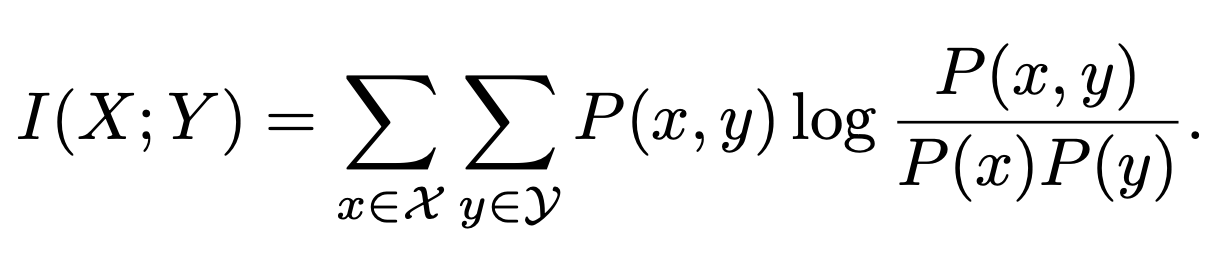

Note that this is an expectation of point-wise mutial information. 

Now, is we let $x$ stand for a word in a document, and $y$ for the label of a document, then we can estimate the values of each of the component probabilities and compute $I$.

To create a model, we can choose the value of $y$ with the maximum value for a given word $x$. Then we can apply this model to a test set.

# Set Up

## Configure

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"

In [3]:
class Params:
    smooth_alpha = .1

## Import

In [4]:
import pandas as pd
import numpy as np
import plotly_express as px

# Preparation

## Get Data

In [5]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [6]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Training

## Label $P(y)$

In [7]:
TOKEN_CLASS = X_train.join(y_train.to_frame('doc_label'), how='inner').groupby('doc_label').sum().T

In [8]:
TOKEN_CLASS

doc_label      N   P
000           38  33
01             0   3
02             2   1
03             1   2
035            0   1
...           ..  ..
öküzgözü       1   1
über           2   9
überaromatic   0   1
ürzig          0   1
ürziger        0   1

[20772 rows x 2 columns]

In [9]:
CLASS = (TOKEN_CLASS.sum() / TOKEN_CLASS.sum().sum()).to_frame('p_y')

In [10]:
CLASS

p_y
doc_label          
N          0.439827
P          0.560173

## Word $P(x)$

In [11]:
X_train_smooth = X_train + Params.smooth_alpha

In [12]:
VOCAB = (X_train_smooth.sum() / X_train_smooth.sum().sum()).to_frame('p_x')
VOCAB.index.name = 'term_str'

In [13]:
VOCAB

p_x
term_str              
000           0.000049
01            0.000048
02            0.000048
03            0.000048
035           0.000048
...                ...
öküzgözü      0.000048
über          0.000048
überaromatic  0.000048
ürzig         0.000048
ürziger       0.000048

[20772 rows x 1 columns]

## Word and Label $P(x,y)$

In [14]:
TOKEN_CLASS_SMOOTH = TOKEN_CLASS + Params.smooth_alpha

In [15]:
TOKEN_CLASS_NARROW = (TOKEN_CLASS_SMOOTH / TOKEN_CLASS_SMOOTH.sum().sum()).unstack().to_frame('p_xy')

In [16]:
TOKEN_CLASS_NARROW.index.names = ['doc_label', 'term_str']

In [17]:
TOKEN_CLASS_NARROW

p_xy
doc_label term_str                  
N         000           4.892969e-05
          01            1.284244e-07
          02            2.696912e-06
          03            1.412668e-06
          035           1.284244e-07
...                              ...
P         öküzgözü      1.412668e-06
          über          1.168662e-05
          überaromatic  1.412668e-06
          ürzig         1.412668e-06
          ürziger       1.412668e-06

[41544 rows x 1 columns]

## Point-wise mutual information

$pmi(x;y) = log_2(\large\frac{P(x,y)}{P(x)P(y)})$

In [18]:
TOKEN_CLASS_NARROW = TOKEN_CLASS_NARROW.join(VOCAB.p_x).join(CLASS.p_y)

In [19]:
TOKEN_CLASS_NARROW

p_xy       p_x       p_y
doc_label term_str                                      
N         000           4.892969e-05  0.000049  0.439827
          01            1.284244e-07  0.000048  0.439827
          02            2.696912e-06  0.000048  0.439827
          03            1.412668e-06  0.000048  0.439827
          035           1.284244e-07  0.000048  0.439827
...                              ...       ...       ...
P         öküzgözü      1.412668e-06  0.000048  0.560173
          über          1.168662e-05  0.000048  0.560173
          überaromatic  1.412668e-06  0.000048  0.560173
          ürzig         1.412668e-06  0.000048  0.560173
          ürziger       1.412668e-06  0.000048  0.560173

[41544 rows x 3 columns]

In [20]:
TOKEN_CLASS_NARROW['pmi'] = np.log2(TOKEN_CLASS_NARROW.p_xy/(TOKEN_CLASS_NARROW.p_x * TOKEN_CLASS_NARROW.p_y))

In [21]:
TOKEN_CLASS_NARROW

p_xy       p_x       p_y       pmi
doc_label term_str                                                
N         000           4.892969e-05  0.000049  0.439827  1.193468
          01            1.284244e-07  0.000048  0.439827 -7.349871
          02            2.696912e-06  0.000048  0.439827 -2.957554
          03            1.412668e-06  0.000048  0.439827 -3.890440
          035           1.284244e-07  0.000048  0.439827 -7.348970
...                              ...       ...       ...       ...
P         öküzgözü      1.412668e-06  0.000048  0.560173 -4.238927
          über          1.168662e-05  0.000048  0.560173 -1.194613
          überaromatic  1.412668e-06  0.000048  0.560173 -4.238476
          ürzig         1.412668e-06  0.000048  0.560173 -4.238476
          ürziger       1.412668e-06  0.000048  0.560173 -4.238476

[41544 rows x 4 columns]

In [22]:
PMI = TOKEN_CLASS_NARROW.pmi.unstack().T

In [23]:
PMI

doc_label            N         P
term_str                        
000           1.193468  0.641571
01           -7.349871 -2.744613
02           -2.957554 -4.239377
03           -3.890440 -3.306491
035          -7.348970 -4.238476
...                ...       ...
öküzgözü     -3.889989 -4.238927
über         -2.961153 -1.194613
überaromatic -7.348970 -4.238476
ürzig        -7.348970 -4.238476
ürziger      -7.348970 -4.238476

[20772 rows x 2 columns]

## EMI

In [24]:
TOKEN_CLASS_NARROW['emi'] = TOKEN_CLASS_NARROW.p_xy * TOKEN_CLASS_NARROW.pmi

In [25]:
EMI = TOKEN_CLASS_NARROW.emi.unstack().T

In [26]:
EMI

doc_label                N         P
term_str                            
000           5.839601e-05  0.000027
01           -9.439026e-07 -0.000011
02           -7.976262e-06 -0.000006
03           -5.495900e-06 -0.000009
035          -9.437869e-07 -0.000006
...                    ...       ...
öküzgözü     -5.495264e-06 -0.000006
über         -7.985968e-06 -0.000014
überaromatic -9.437869e-07 -0.000006
ürzig        -9.437869e-07 -0.000006
ürziger      -9.437869e-07 -0.000006

[20772 rows x 2 columns]

# Testing

In [27]:
X_test.dot(EMI)

doc_label         N         P
doc_id                       
16         0.298312  0.264569
72         0.255581  0.268727
73         0.124480  0.155730
87         0.108112  0.139551
97         0.288739  0.293722
...             ...       ...
129940     0.178927  0.185032
129947     0.291202  0.307203
129948     0.203325  0.195099
129961     0.296116  0.310191
129970     0.112989  0.146872

[8000 rows x 2 columns]

In [28]:
y_hat = X_test.dot(EMI).idxmax(1)

In [52]:
y_hat

doc_id
16        N
72        P
73        P
87        P
97        P
         ..
129940    P
129947    P
129948    N
129961    P
129970    P
Length: 8000, dtype: object

# Evaluation

In [53]:
RESULT = pd.concat([y_test, y_hat], axis=1)
RESULT.columns = ['doc_label', 'prediction']

In [54]:
RESULT['result'] = RESULT.doc_label == RESULT.prediction

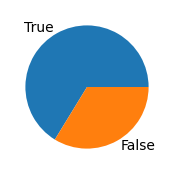

In [55]:
RESULT.value_counts('result').plot.pie(figsize=(2,2));

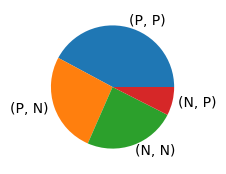

In [56]:
RESULT.value_counts(['prediction','doc_label']).plot.pie(figsize=(2,2));

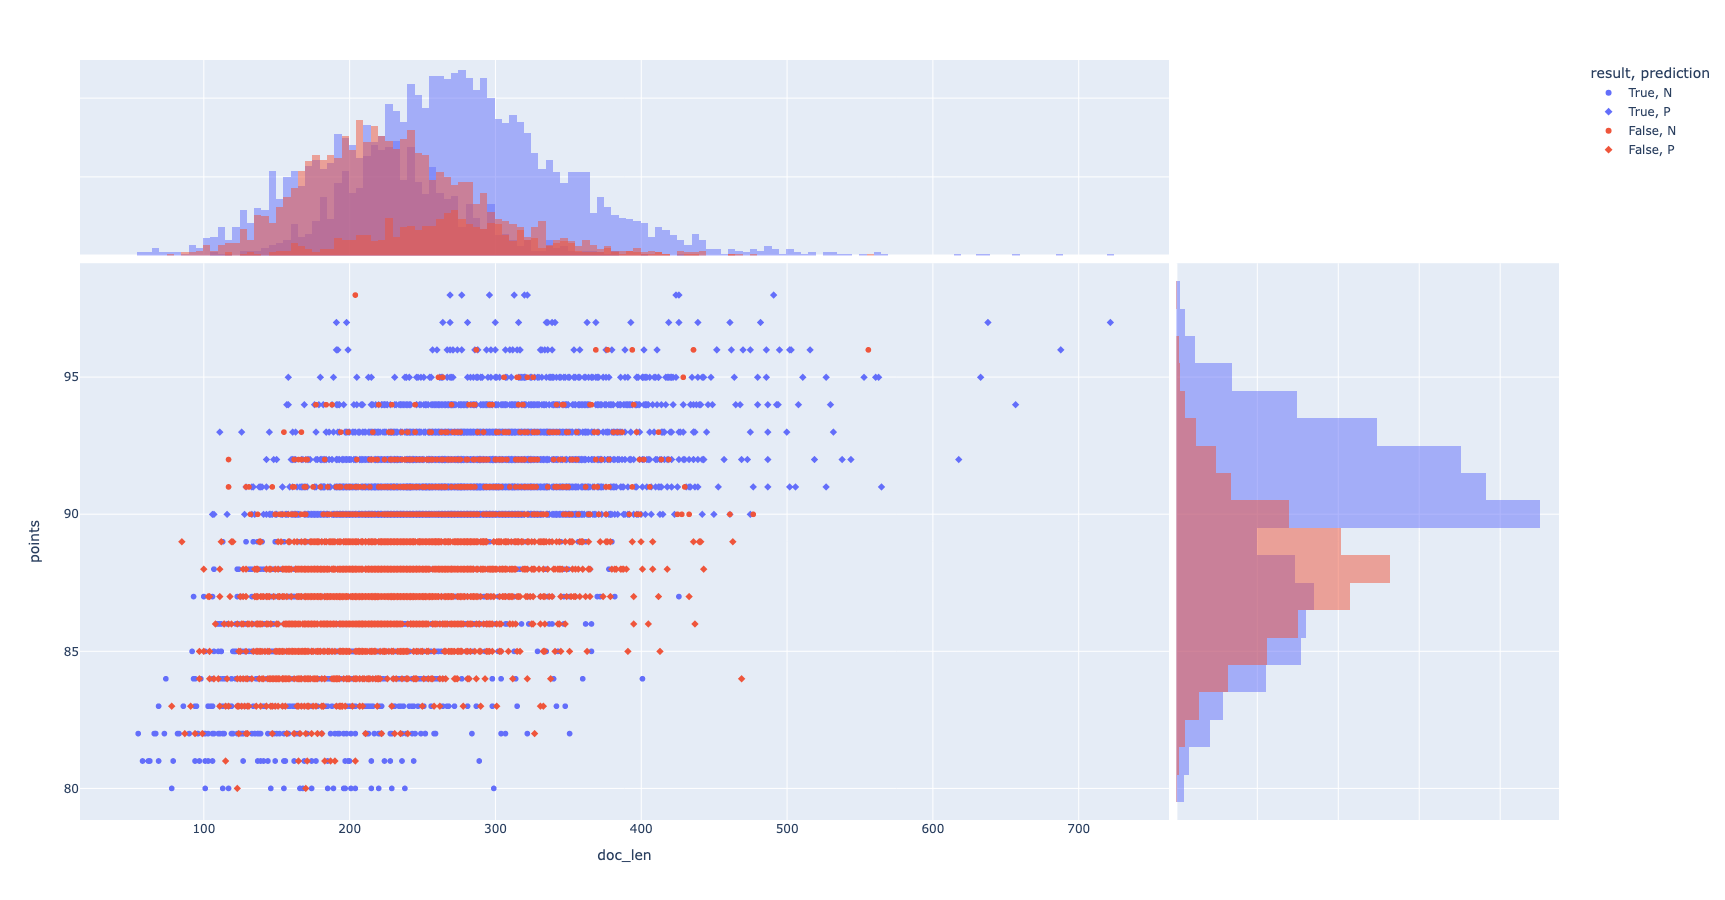

In [57]:
px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner').reset_index(), 'doc_len', 'points', color='result', symbol='prediction',
           height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [58]:
CM = RESULT.value_counts(['prediction','doc_label']).unstack()

In [59]:
CM

doc_label      N     P
prediction            
N           1928   598
P           2101  3373

In [60]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [61]:
R = get_results(CM, 'mi')
R.index.name = 'model_id'

In [62]:
R.T.style.format(precision=3)

# Extract Sentiment

In [63]:
SALEX = PMI
SALEX['valence'] = SALEX.P - SALEX.N
SALEX = SALEX.sort_values('valence')

In [64]:
SALEX['polarity'] = np.sign(SALEX.valence)

In [65]:
from sklearn.preprocessing import MinMaxScaler

In [66]:
scaler = MinMaxScaler(feature_range=(-1, 1))
SALEX['normalized'] = scaler.fit_transform(SALEX[['valence']])

In [67]:
SALEX.sort_values('valence', ascending=False).head(20)

doc_label           N         P   valence  polarity  normalized
term_str                                                       
92          -7.387658  2.046403  9.434061       1.0    1.000000
2027        -7.381502  1.802890  9.184392       1.0    0.973371
94          -7.373105  1.383866  8.756971       1.0    0.927784
exquisite   -7.365996  0.896091  8.262087       1.0    0.875001
chaparral   -7.361088  0.424401  7.785489       1.0    0.824168
2032        -7.360641  0.372570  7.733211       1.0    0.818592
2035        -7.360194  0.318775  7.678968       1.0    0.812807
deserves    -7.359747  0.262859  7.622606       1.0    0.806795
sublime     -7.359747  0.262859  7.622606       1.0    0.806795
2031        -7.358404  0.080561  7.438965       1.0    0.787209
2029        -7.358404  0.080561  7.438965       1.0    0.787209
superbly    -7.357956  0.014205  7.372162       1.0    0.780084
coiled      -7.357956  0.014205  7.372162       1.0    0.780084
magnificent -7.357508 -0.055394  7.302114       1.0    0.772613
awesome     -7.357508 -0.055394  7.302114       1.0    0.772613
stunner     -7.356612 -0.205703  7.150908       1.0    0.756485
josh        -7.356163 -0.287248  7.068915       1.0    0.747740
corton      -7.355715 -0.373736  6.981979       1.0    0.738468
thrilling   -7.355715 -0.373736  6.981979       1.0    0.738468
2040        -7.355715 -0.373736  6.981979       1.0    0.738468

In [68]:
SALEX.sort_values('valence', ascending=True).head(20)

doc_label           N         P   valence  polarity  normalized
term_str                                                       
dilute       1.597780 -7.719825 -9.317604      -1.0   -1.000000
watery       1.448318 -7.717604 -9.165921      -1.0   -0.983822
raspy        1.245029 -7.714933 -8.959962      -1.0   -0.961855
weedy        0.773338 -7.710026 -8.483364      -1.0   -0.911022
murky        0.553590 -7.708237 -8.261827      -1.0   -0.887394
fuss         0.553590 -7.708237 -8.261827      -1.0   -0.887394
diluted      0.363143 -7.706894 -8.070037      -1.0   -0.866938
torrontés    0.220369 -7.705998 -7.926366      -1.0   -0.851614
detracts     0.143234 -7.705549 -7.848783      -1.0   -0.843340
sketchy     -0.116861 -7.704204 -7.587342      -1.0   -0.815455
struggles   -0.116861 -7.704204 -7.587342      -1.0   -0.815455
strained    -0.116861 -7.704204 -7.587342      -1.0   -0.815455
monotone    -0.215266 -7.703755 -7.488489      -1.0   -0.804912
clipped     -0.215266 -7.703755 -7.488489      -1.0   -0.804912
usa         -0.215266 -7.703755 -7.488489      -1.0   -0.804912
everyday     3.108835 -4.303253 -7.412087      -1.0   -0.796763
serviceable -0.320945 -7.703306 -7.382361      -1.0   -0.793592
inzolia     -0.320945 -7.703306 -7.382361      -1.0   -0.793592
pyrazines   -0.435056 -7.702857 -7.267801      -1.0   -0.781374
appley      -0.435056 -7.702857 -7.267801      -1.0   -0.781374

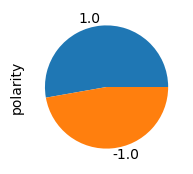

In [69]:
SALEX.polarity.value_counts().plot.pie(figsize=(2,2));

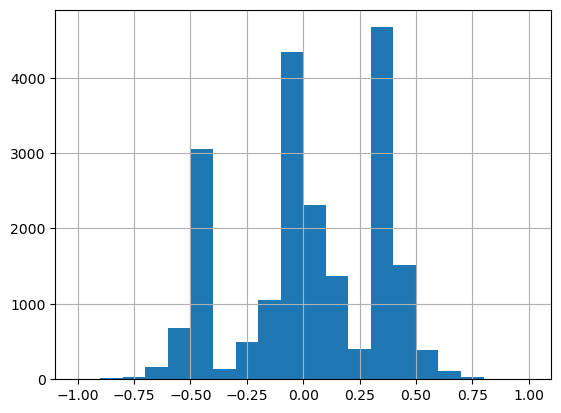

In [70]:
SALEX.normalized.hist(bins=20);

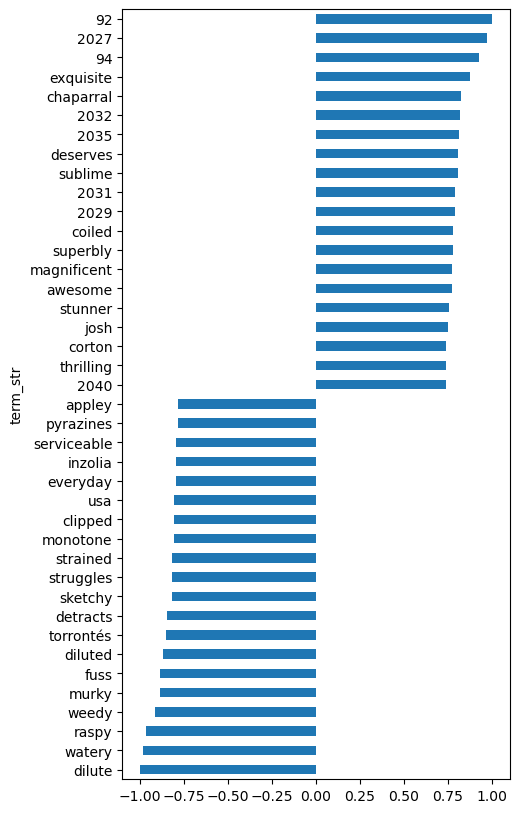

In [71]:
pd.concat([SALEX.normalized.head(20),SALEX.normalized.tail(20)]).plot.barh(figsize=(5,10));

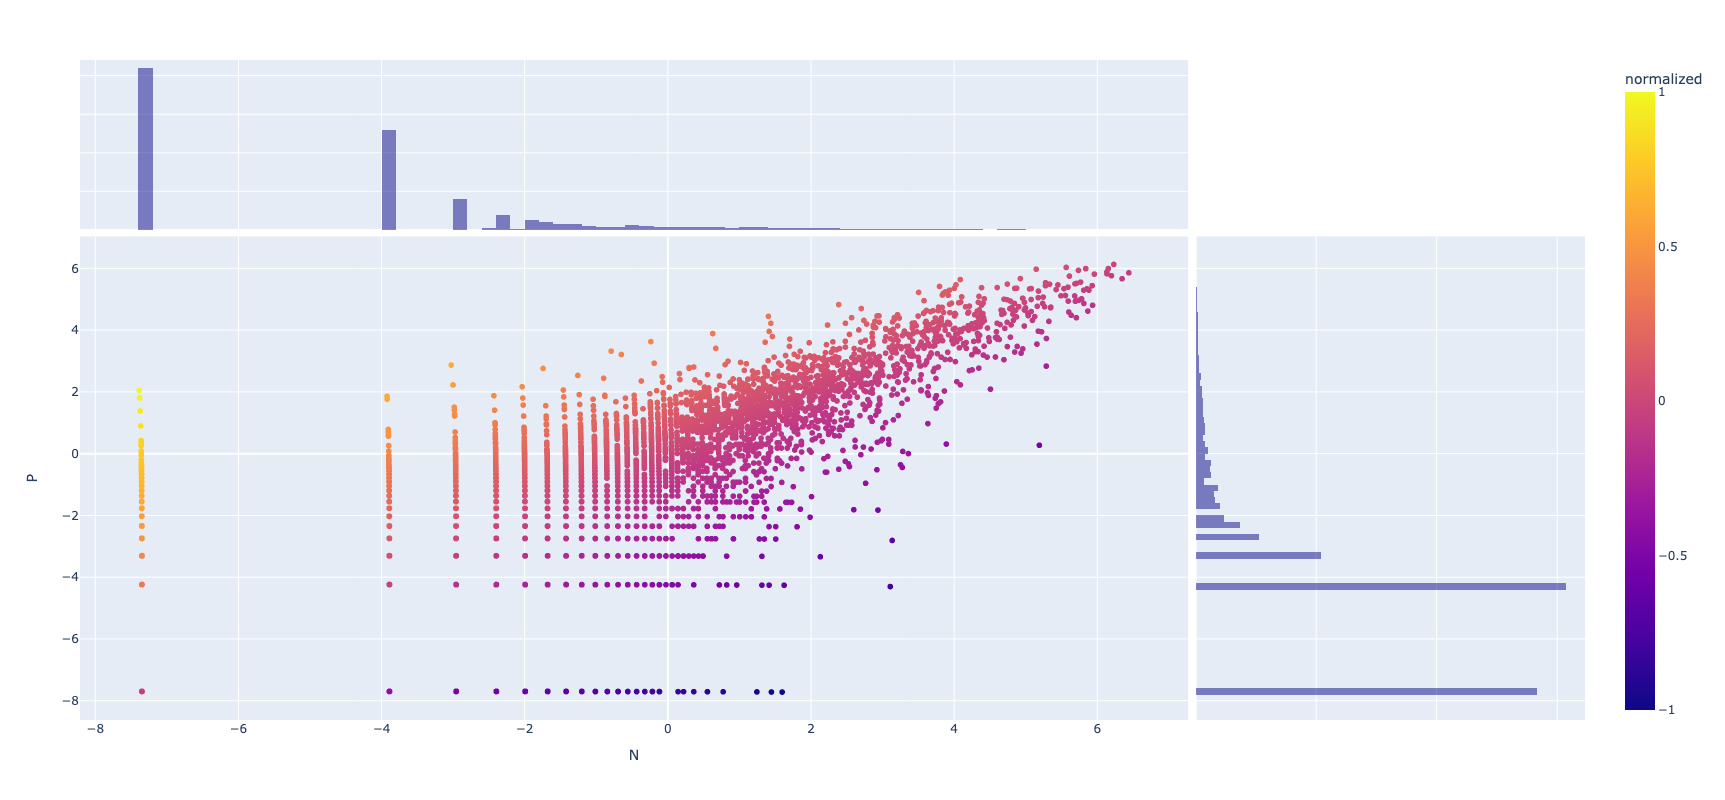

In [72]:
px.scatter(SALEX.reset_index(), 'N', 'P', 
           color='normalized', 
           height=800, width=1000, 
           hover_name='term_str', 
           marginal_x='histogram', marginal_y='histogram')

# Save

In [73]:
SALEX[['valence','polarity','normalized']].to_csv(f"{data_path}-MI_SALEX.csv")

In [74]:
R.to_csv(f"{data_path}-MI_RESULT.csv", index=True)